### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Data

In [2]:
df = pd.read_csv("merged-df.csv")

In [3]:
df = df.drop(columns=['user_address','card_has_chip','card_cvv','card_year_pin_last_changed','card_card_on_dark_web'],axis=1)

In [4]:
df2 = pd.read_csv("final_features_updated.csv")

#### Merging both dataframes

To merge both dataframes, created features `num_credit_cards`, `num_debit_cards`, and `card_credit_limit` to retain useful card related info.

In [6]:
user_level = (
    df.groupby('user_id')
      .agg(
          num_credit_cards=('card_id', lambda x: df.loc[x.index, 'card_card_type'][df.loc[x.index, 'card_card_type'] == 'Credit'].nunique()),
          num_debit_cards=('card_id', lambda x: df.loc[x.index, 'card_card_type'][df.loc[x.index, 'card_card_type'].str.contains('Debit', case=False, na=False)].nunique()),
          avg_credit_limit=('card_credit_limit', 'mean')
      )
      .reset_index()
)

In [7]:
credit_cards = df[df['card_card_type'] == 'Credit']
debit_cards  = df[df['card_card_type'].str.contains('Debit', case=False, na=False)]

credit_counts = credit_cards.groupby('user_id')['card_id'].nunique().rename('num_credit_cards')
debit_counts  = debit_cards.groupby('user_id')['card_id'].nunique().rename('num_debit_cards')
avg_credit_limit = df.groupby('user_id')['card_credit_limit'].mean().rename('avg_credit_limit')

user_level = pd.concat([credit_counts, debit_counts, avg_credit_limit], axis=1).fillna(0).reset_index()

In [9]:
final_df = df2.merge(user_level, on='user_id', how='left')

In [12]:
final_df.shape

(1219, 35)

In [13]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1219 entries, 0 to 1218
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   user_id                      1219 non-null   int64  
 1   total_txn_count              1219 non-null   int64  
 2   total_amount                 1219 non-null   float64
 3   avg_amount                   1219 non-null   float64
 4   std_amount                   1219 non-null   float64
 5   median_amount                1219 non-null   float64
 6   first_txn                    1219 non-null   object 
 7   last_txn                     1219 non-null   object 
 8   user_gender                  1219 non-null   object 
 9   user_current_age             1219 non-null   int64  
 10  user_birth_year              1219 non-null   int64  
 11  user_yearly_income           1219 non-null   float64
 12  user_per_capita_income       1219 non-null   float64
 13  user_credit_score 

### Preprocessing

#### Converting datatypes

In [15]:
final_df['first_txn'] = pd.to_datetime(final_df['first_txn'], errors='coerce')
final_df['last_txn']  = pd.to_datetime(final_df['last_txn'],  errors='coerce')

In [26]:
cat_cols = ['user_gender', 'risk_level', 'trend_category', 'card_num_cards_issued', 'num_credit_cards', 'num_debit_cards']
final_df[cat_cols] = final_df[cat_cols].astype('category')

#### Missingness check

In [17]:
missing_summary = final_df.isna().sum().sort_values(ascending=False)
print(missing_summary[missing_summary > 0])

Series([], dtype: int64)


#### Duplicates check

In [18]:
dup_count = final_df.duplicated().sum()
print(f"Total duplicate rows: {dup_count}")

Total duplicate rows: 0


In [19]:
nunique = final_df.nunique()
constant_cols = nunique[nunique == 1].index.tolist()
constant_cols

[]

No duplicate rows or columns with constant value.

### Exploratory Data Analysis
#### Customer Transaction Behavior Overview

In [22]:
pd.set_option('display.max_columns', None)
final_df.head(5)

,user_id,total_txn_count,total_amount,avg_amount,std_amount,median_amount,first_txn,last_txn,user_gender,user_current_age,user_birth_year,user_yearly_income,user_per_capita_income,user_credit_score,user_total_debt,user_retirement_age,user_birth_month,card_num_cards_issued,user_latitude,user_longitude,year_to_retirement,debt_to_yearly_income_ratio,income_per_card,multi_card_user,income_utilization_ratio,credit_utilization_ratio,oldest_card_age_years,weekend_spend_ratio,correlation_with_trend,trend_category,risk_of_default_score,risk_level,num_credit_cards,num_debit_cards,avg_credit_limit
0,0,12795,625799.67,48.909705,84.635746,44.190,2010-01-01 13:10:00,2019-10-31 19:14:00,Male,33,1986,59613.0,29237.0,763,36199.0,69,3,1,43.59,-70.33,36,0.607233,59613.0,0,1.067563,0.002166,18,0.278277,0.232929,Does Not Follow Trend,0.208002,Low,1.0,1.0,25081.819461
1,1,10073,336187.37,33.375099,52.139254,16.130,2010-01-01 11:58:00,2019-10-31 16:15:00,Female,43,1976,45360.0,22247.0,704,14587.0,74,4,1,30.44,-87.18,31,0.321583,45360.0,0,0.753716,0.002504,23,0.289232,0.285515,Follows Trend,0.200631,Low,2.0,1.0,14115.737615
2,2,10612,291534.27,27.472132,43.120595,22.615,2010-01-01 06:47:00,2019-10-31 16:21:00,Male,48,1971,27447.0,13461.0,673,80850.0,64,8,1,40.84,-73.87,16,2.945677,27447.0,0,1.080175,0.002959,20,0.280503,0.188360,Does Not Follow Trend,0.467219,Medium,2.0,3.0,10130.488032
3,3,6001,280685.46,46.773114,40.747430,50.740,2010-01-02 17:15:00,2019-10-31 14:30:00,Male,49,1970,27943.0,13705.0,681,18693.0,65,12,1,33.89,-98.51,16,0.668969,27943.0,0,1.021518,0.515529,18,0.283297,0.139144,Does Not Follow Trend,0.290490,Low,0.0,4.0,2241.723213
4,4,15043,595722.36,39.601300,75.924251,29.940,2010-01-01 06:45:00,2019-10-31 21:26:00,Female,54,1965,76431.0,37485.0,716,115362.0,72,3,1,47.61,-122.30,18,1.509361,76431.0,0,0.792636,0.002151,22,0.290495,0.144842,Does Not Follow Trend,0.426492,Medium,1.0,3.0,24192.718274


**Distribution of Transaction Features Across Customers**

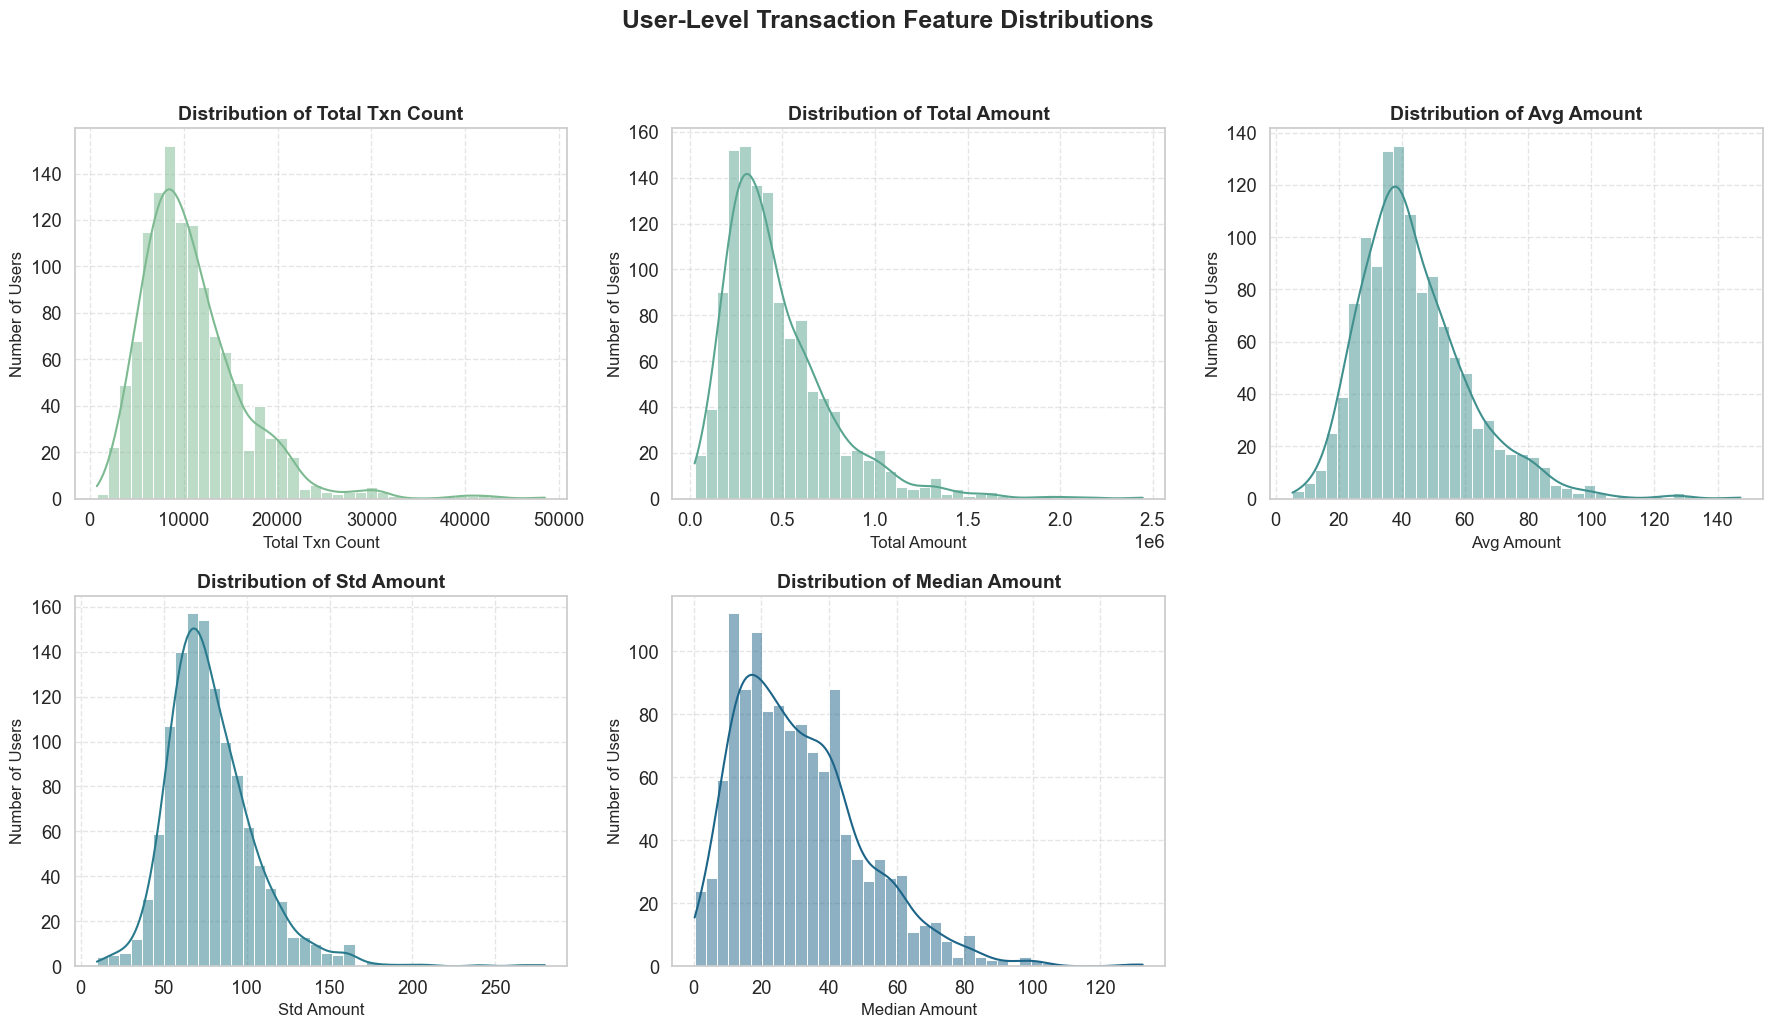

In [24]:
cols = ['total_txn_count', 'total_amount', 'avg_amount', 'std_amount', 'median_amount']
sns.set(style="whitegrid", palette="crest", font_scale=1.2)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(cols):
    sns.histplot(
        data=final_df,
        x=col,
        bins=40,
        kde=True,
        ax=axes[i],
        color=sns.color_palette("crest")[i]
    )
    axes[i].set_title(f"Distribution of {col.replace('_',' ').title()}", fontsize=14, weight='bold')
    axes[i].set_xlabel(col.replace('_',' ').title(), fontsize=12)
    axes[i].set_ylabel("Number of Users", fontsize=12)
    axes[i].grid(True, linestyle='--', alpha=0.5)

if len(cols) < len(axes):
    fig.delaxes(axes[-1])

fig.suptitle("User-Level Transaction Feature Distributions", fontsize=18, weight='bold', y=1.03)
plt.tight_layout()
plt.show()

All five distributions are **right-skewed**.

That’s a common real-world spending pattern → many low/medium users, few high spenders.

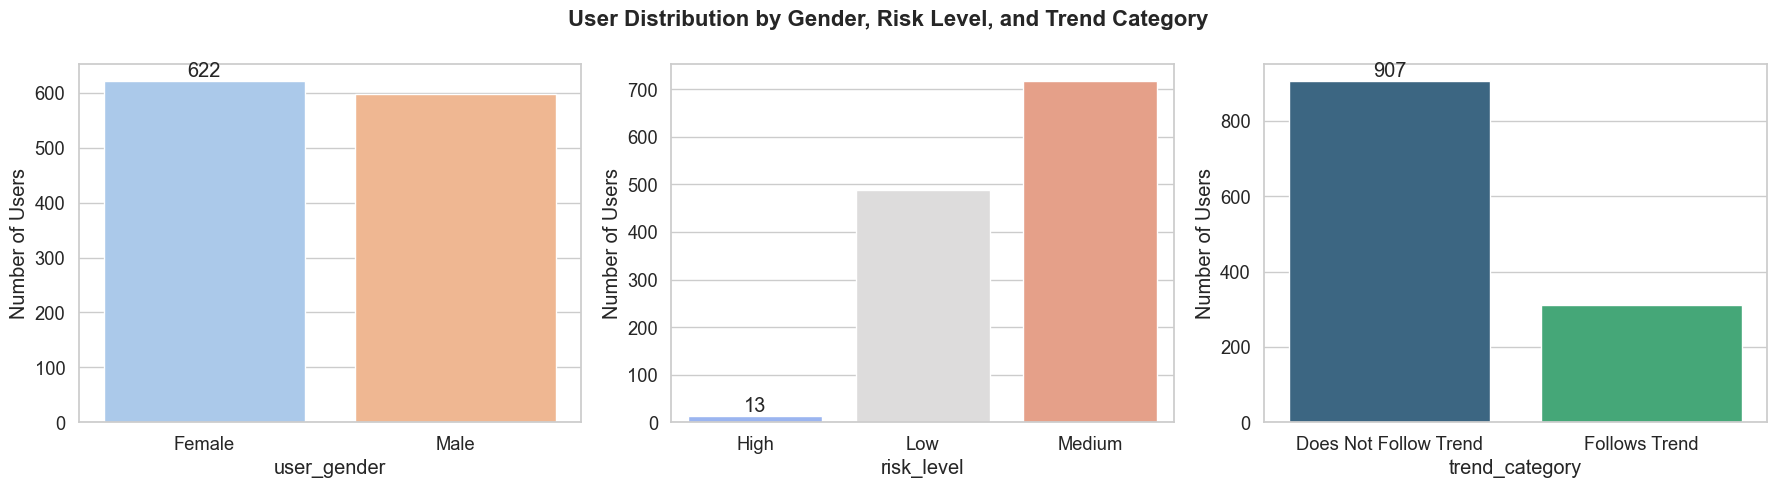

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(data=final_df, x='user_gender', palette='pastel', ax=axes[0])
sns.countplot(data=final_df, x='risk_level', palette='coolwarm', ax=axes[1])
sns.countplot(data=final_df, x='trend_category', palette='viridis', ax=axes[2])
for ax in axes:
    ax.bar_label(ax.containers[0])
    ax.set_ylabel("Number of Users")
plt.suptitle("User Distribution by Gender, Risk Level, and Trend Category", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

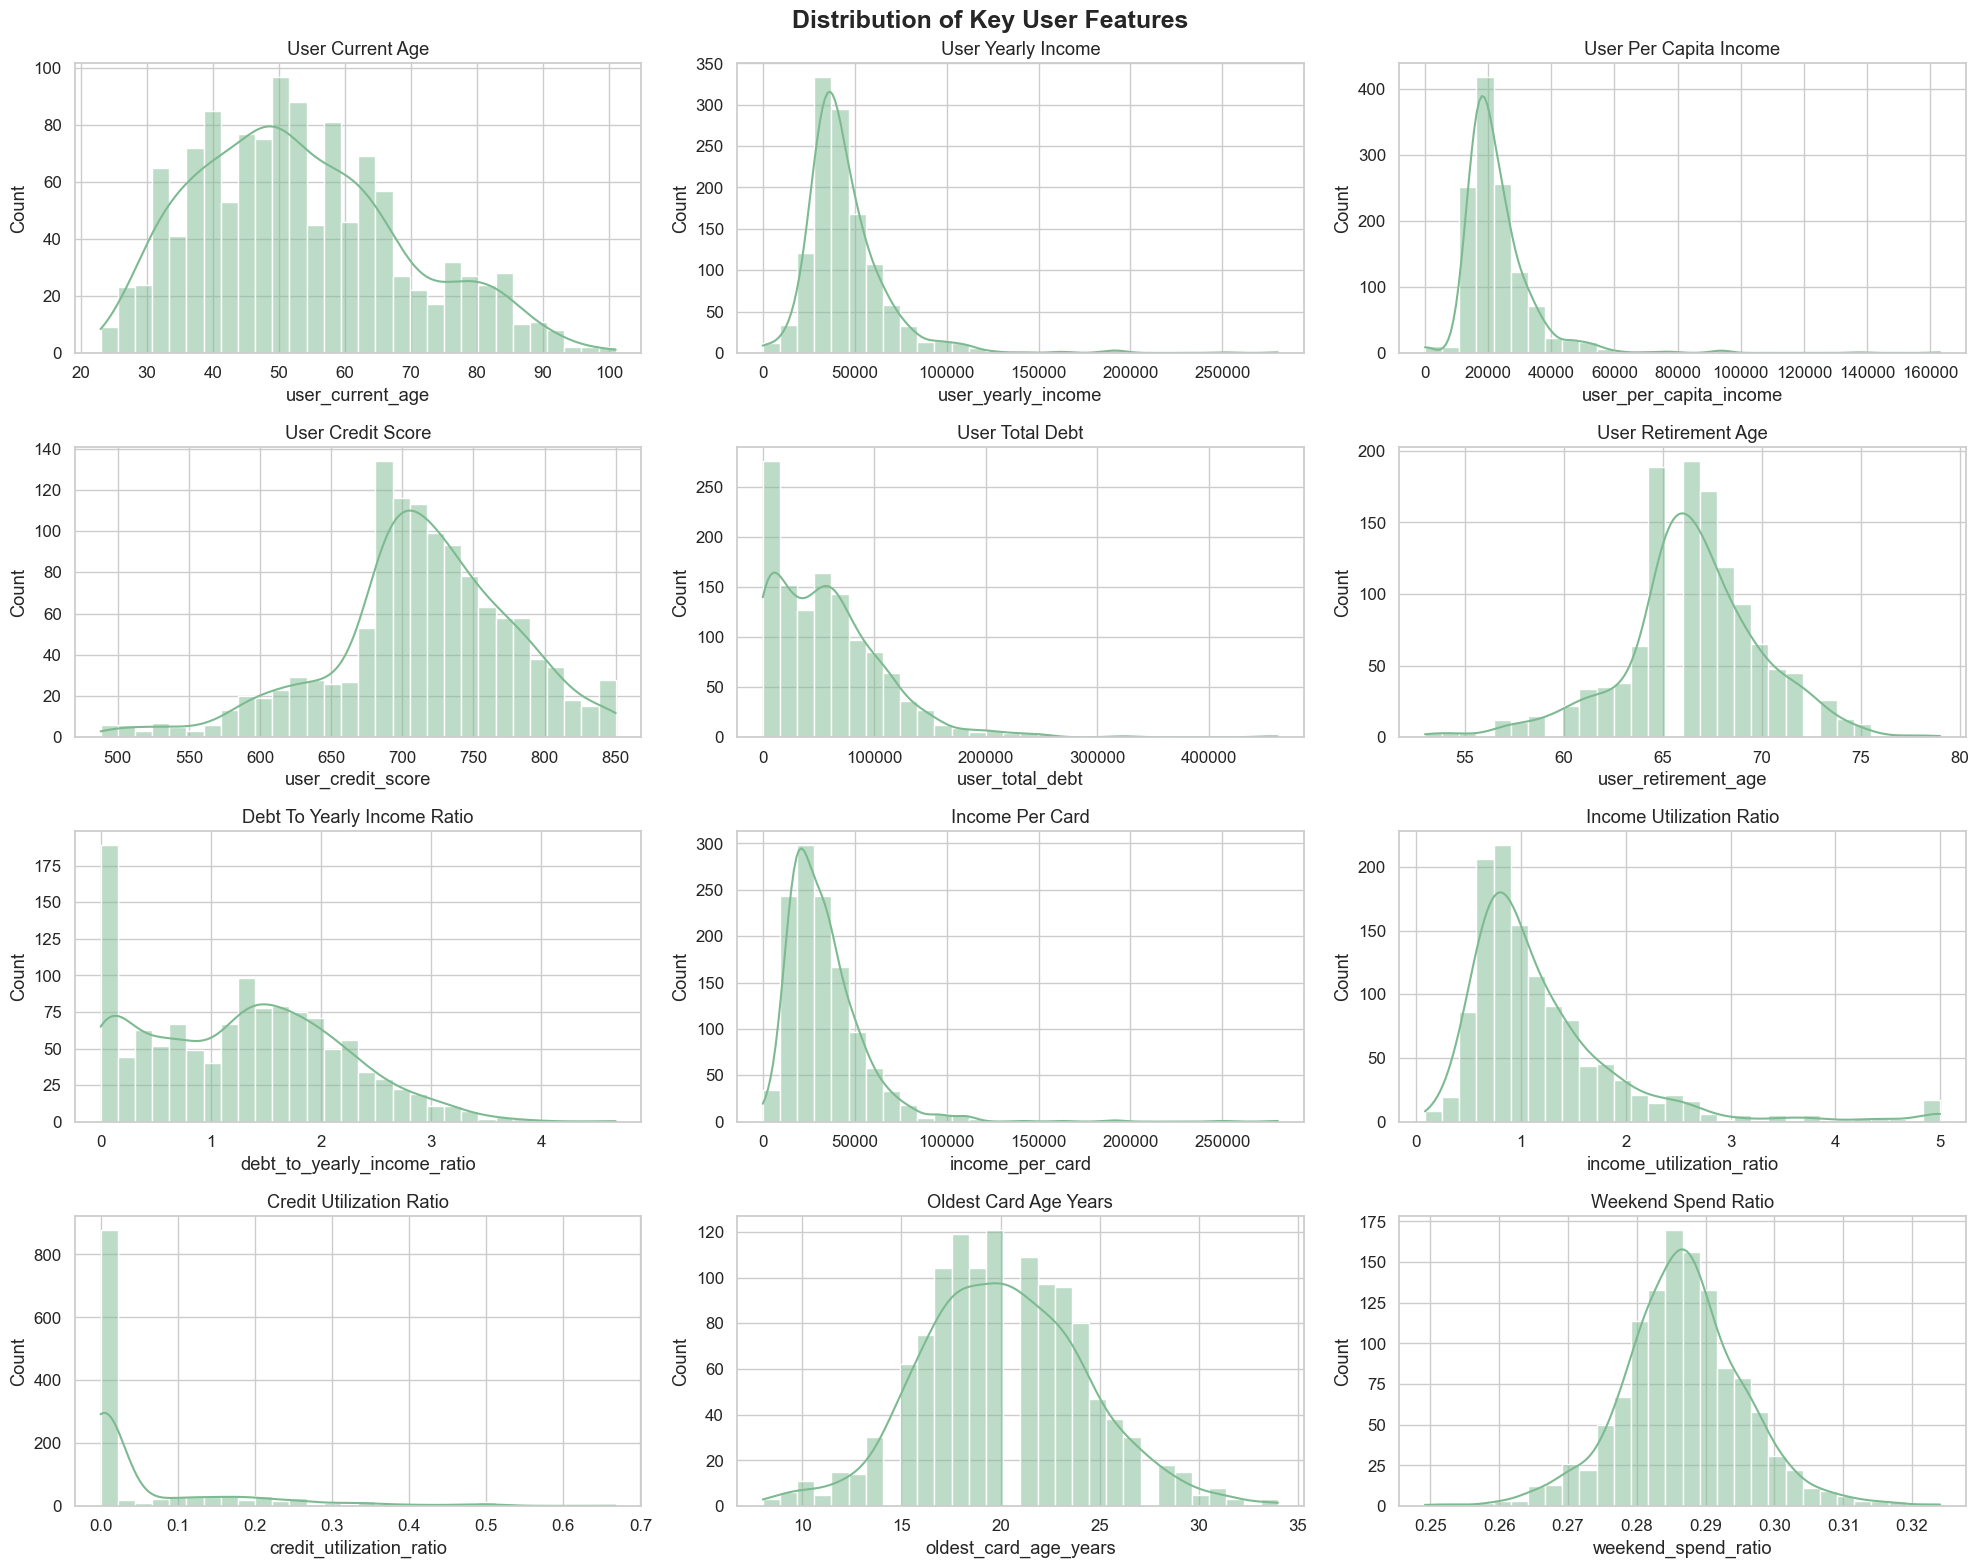

In [28]:
num_cols = [
    'user_current_age', 'user_yearly_income', 'user_per_capita_income', 
    'user_credit_score', 'user_total_debt', 'user_retirement_age', 
    'debt_to_yearly_income_ratio', 'income_per_card', 'income_utilization_ratio',
    'credit_utilization_ratio', 'oldest_card_age_years', 'weekend_spend_ratio'
]

sns.set(style="whitegrid", palette="crest", font_scale=1.1)
fig, axes = plt.subplots(4, 3, figsize=(20, 16))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(final_df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col.replace('_',' ').title())
plt.suptitle("Distribution of Key User Features", fontsize=18, weight='bold')
plt.tight_layout()
plt.show()

**Demographic and Financial Capacity Variables**

- **Age:** Peaking around 40-50
- **Retirement Age:** Around 65
- **Yearly Income and Per-Capita Income:** Both are right-skewed, with most users earning below \$60,000 and a long tail of high-income outliers
---
**Credit and Debt-Related Variables**

- **Credit Score:** Concentrated around 680–720, tapering toward higher scores (~850 max)
- **Total Debt:** Strongly right-skewed, most below \$50K but some exceeding 300K.
- **Debt-to-Yearly-Income Ratio:** Centered around 1–2, meaning many users owe 1–2× their annual income.
---
**Derived Efficiency Ratios**
- **Income Utilization Ratio:** most values peaking around 1 (money earned = money spent)
- **Credit Utilization Ratio:** how much of their credit limit they use on average
- **Income Per Card:** Heavily right-skewed, most users have 20K-40K income per card.

#### Interaction Plots — Relationships Between Key Features

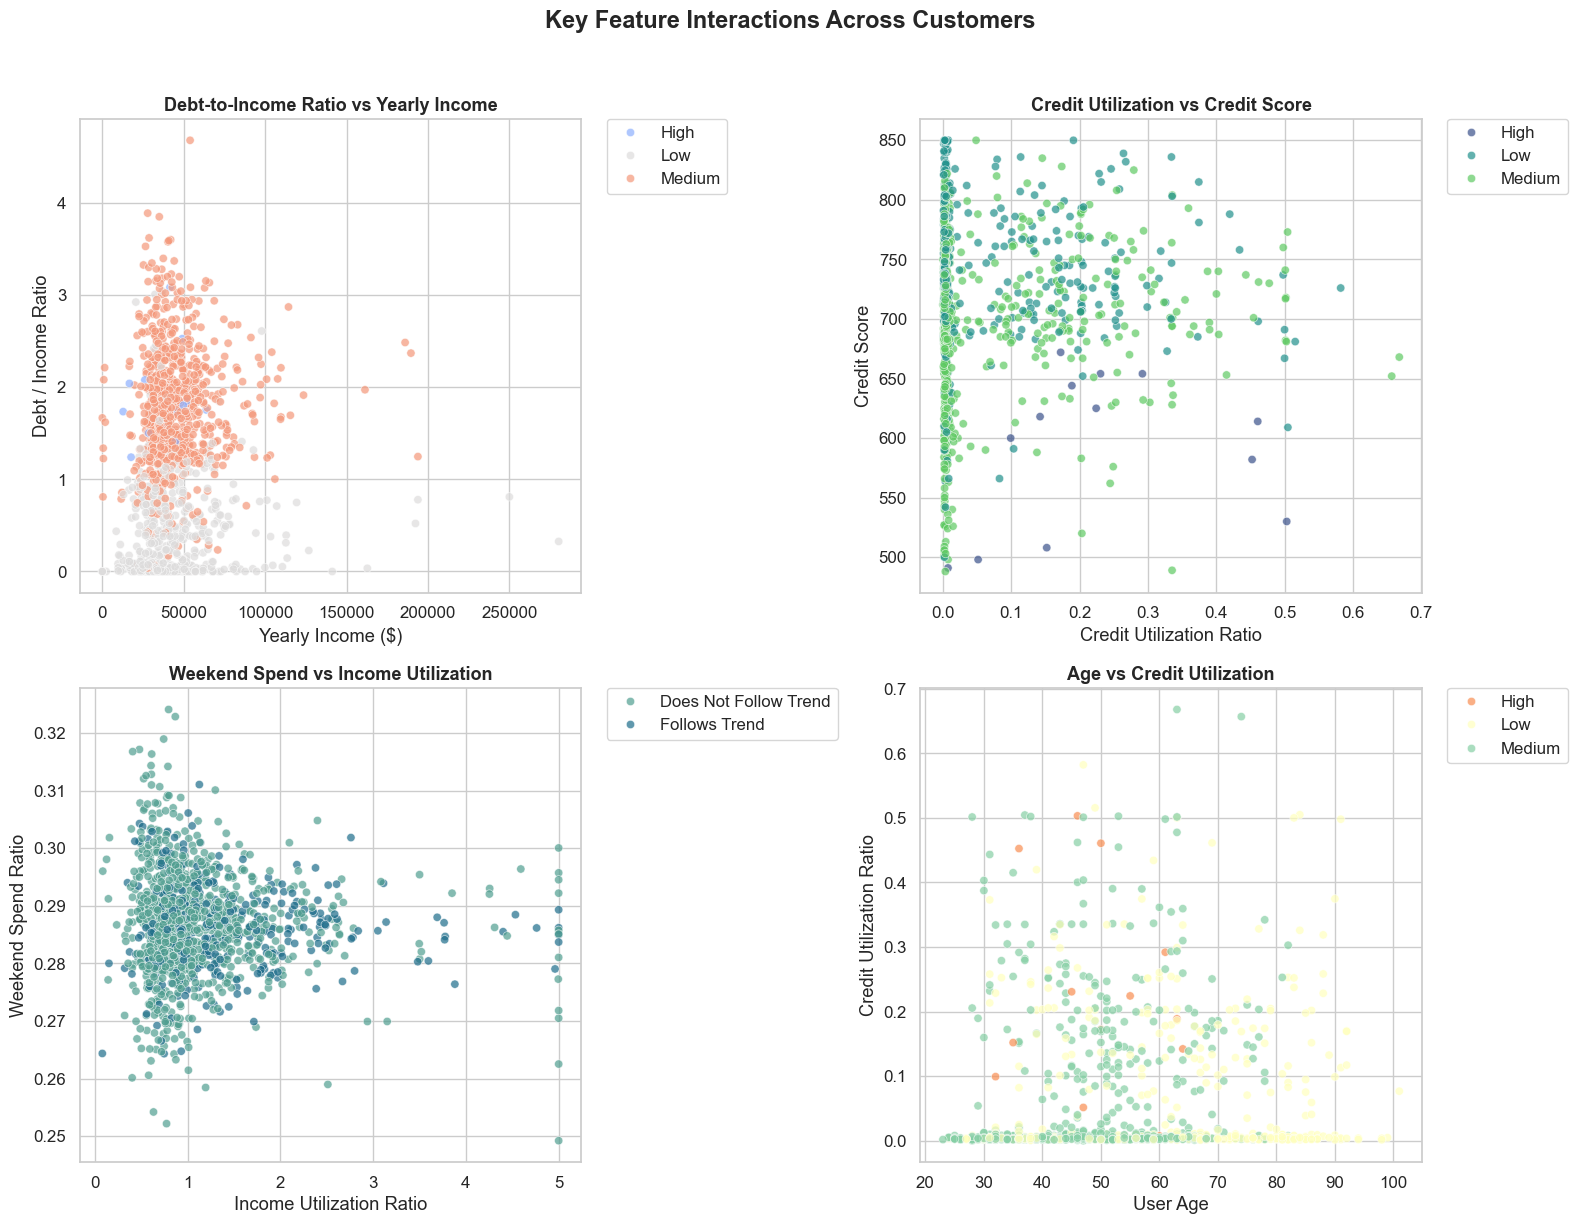

In [33]:
sns.set(style="whitegrid", font_scale=1.1, palette="crest")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.25, wspace=0.25)

# Debt-to-Income Ratio vs Yearly Income
sns.scatterplot(
    data=final_df, x='user_yearly_income', y='debt_to_yearly_income_ratio',
    hue='risk_level', alpha=0.7, ax=axes[0, 0], palette='coolwarm'
)
axes[0, 0].set_title("Debt-to-Income Ratio vs Yearly Income", fontsize=13, weight='bold')
axes[0, 0].set_xlabel("Yearly Income ($)")
axes[0, 0].set_ylabel("Debt / Income Ratio")

# Credit Utilization vs Credit Score
sns.scatterplot(
    data=final_df, x='credit_utilization_ratio', y='user_credit_score',
    hue='risk_level', alpha=0.7, ax=axes[0, 1], palette='viridis'
)
axes[0, 1].set_title("Credit Utilization vs Credit Score", fontsize=13, weight='bold')
axes[0, 1].set_xlabel("Credit Utilization Ratio")
axes[0, 1].set_ylabel("Credit Score")

# Weekend Spend vs Income Utilization
sns.scatterplot(
    data=final_df, x='income_utilization_ratio', y='weekend_spend_ratio',
    hue='trend_category', alpha=0.7, ax=axes[1, 0], palette='crest'
)
axes[1, 0].set_title("Weekend Spend vs Income Utilization", fontsize=13, weight='bold')
axes[1, 0].set_xlabel("Income Utilization Ratio")
axes[1, 0].set_ylabel("Weekend Spend Ratio")

# Age vs Credit Utilization
sns.scatterplot(
    data=final_df, x='user_current_age', y='credit_utilization_ratio',
    hue='risk_level', alpha=0.7, ax=axes[1, 1], palette='Spectral'
)
axes[1, 1].set_title("Age vs Credit Utilization", fontsize=13, weight='bold')
axes[1, 1].set_xlabel("User Age")
axes[1, 1].set_ylabel("Credit Utilization Ratio")

# Tidy legends
for ax in axes.flat:
    ax.legend(title="", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.suptitle("Key Feature Interactions Across Customers", fontsize=17, weight='bold', y=1.02)
plt.tight_layout()
plt.show()

- **Credit Utilization vs. Credit Ratio:** downward relationship - as credit utilization increases, credit score tends to fall.

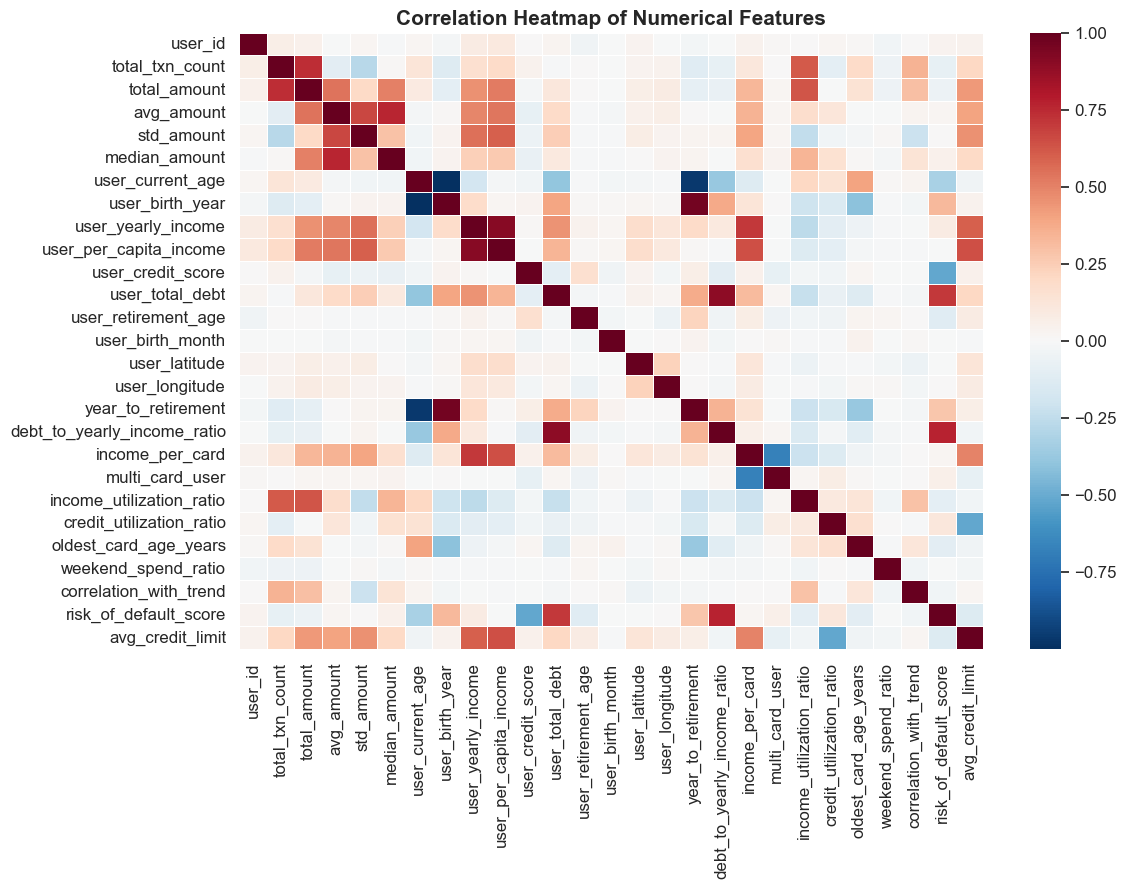

In [39]:
numeric_df = final_df.select_dtypes(include=['number'])

corr = numeric_df.corr(method='spearman')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    cmap='RdBu_r',
    center=0,
    annot=False,
    linewidths=0.5
)
plt.title("Correlation Heatmap of Numerical Features", fontsize=15, weight='bold')
plt.show()

In [42]:
threshold = 0.8
corr_pairs = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    .stack()  # convert to long form
    .reset_index()
)
corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr = corr_pairs.loc[corr_pairs['Correlation'].abs() > threshold].sort_values(
    by='Correlation', ascending=False
)

print(f"\n Highly correlated feature pairs (|ρ| > {threshold}):")
print(high_corr.to_string(index=False))


 Highly correlated feature pairs (|ρ| > 0.8):
         Feature 1                   Feature 2  Correlation
   user_birth_year          year_to_retirement     0.966618
user_yearly_income      user_per_capita_income     0.911388
   user_total_debt debt_to_yearly_income_ratio     0.890834
  user_current_age          year_to_retirement    -0.967185
  user_current_age             user_birth_year    -0.999641


### Summary of Insights from EDA

- Spending and income variables show **right-skewed heavy tails** — most customers transact modestly, while a small group drives very high volume and spend.  
- Financial ratios such as **debt-to-income** and **credit utilization** reveal clear behavioral gradients — from conservative to credit-dependent users.  
- **Credit score** inversely relates to credit utilization, confirming that high-usage customers are riskier.  
- Users vary by **age, income, and utilization**, forming a basis for behavioral segmentation.

**→ Next Step:** Based on these multi-dimensional differences, we will perform **unsupervised clustering** to identify distinct user segments (e.g., low-income high spenders, high-income low-risk savers, lifestyle-driven trend followers).
